## Imports

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from dataloader import DataLoader

## Data loading

Craditcard class info: <br>
class=1 is fraud, <br>
class=0 is otherwise-notFraud

In [17]:
dl = DataLoader()
creditcard_df = dl.load_creditcard()
creditcard_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# EDA

In [18]:
print("Summary statistics of numerical columns:")
print(creditcard_df.describe())

Summary statistics of numerical columns:
                Time            V1  ...         Amount          Class
count  284807.000000  2.848070e+05  ...  284807.000000  284807.000000
mean    94813.859575  1.168375e-15  ...      88.349619       0.001727
std     47488.145955  1.958696e+00  ...     250.120109       0.041527
min         0.000000 -5.640751e+01  ...       0.000000       0.000000
25%     54201.500000 -9.203734e-01  ...       5.600000       0.000000
50%     84692.000000  1.810880e-02  ...      22.000000       0.000000
75%    139320.500000  1.315642e+00  ...      77.165000       0.000000
max    172792.000000  2.454930e+00  ...   25691.160000       1.000000

[8 rows x 31 columns]


In [22]:
print("\nMissing values:")
print(creditcard_df.isnull().sum())


Missing values:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


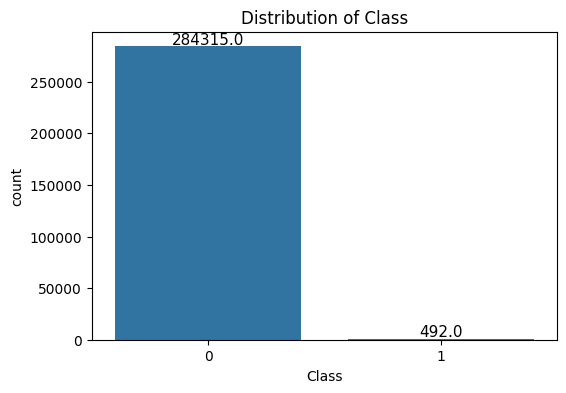

In [19]:
# Plotting class distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='Class', data=creditcard_df)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Distribution of Class')
plt.show()

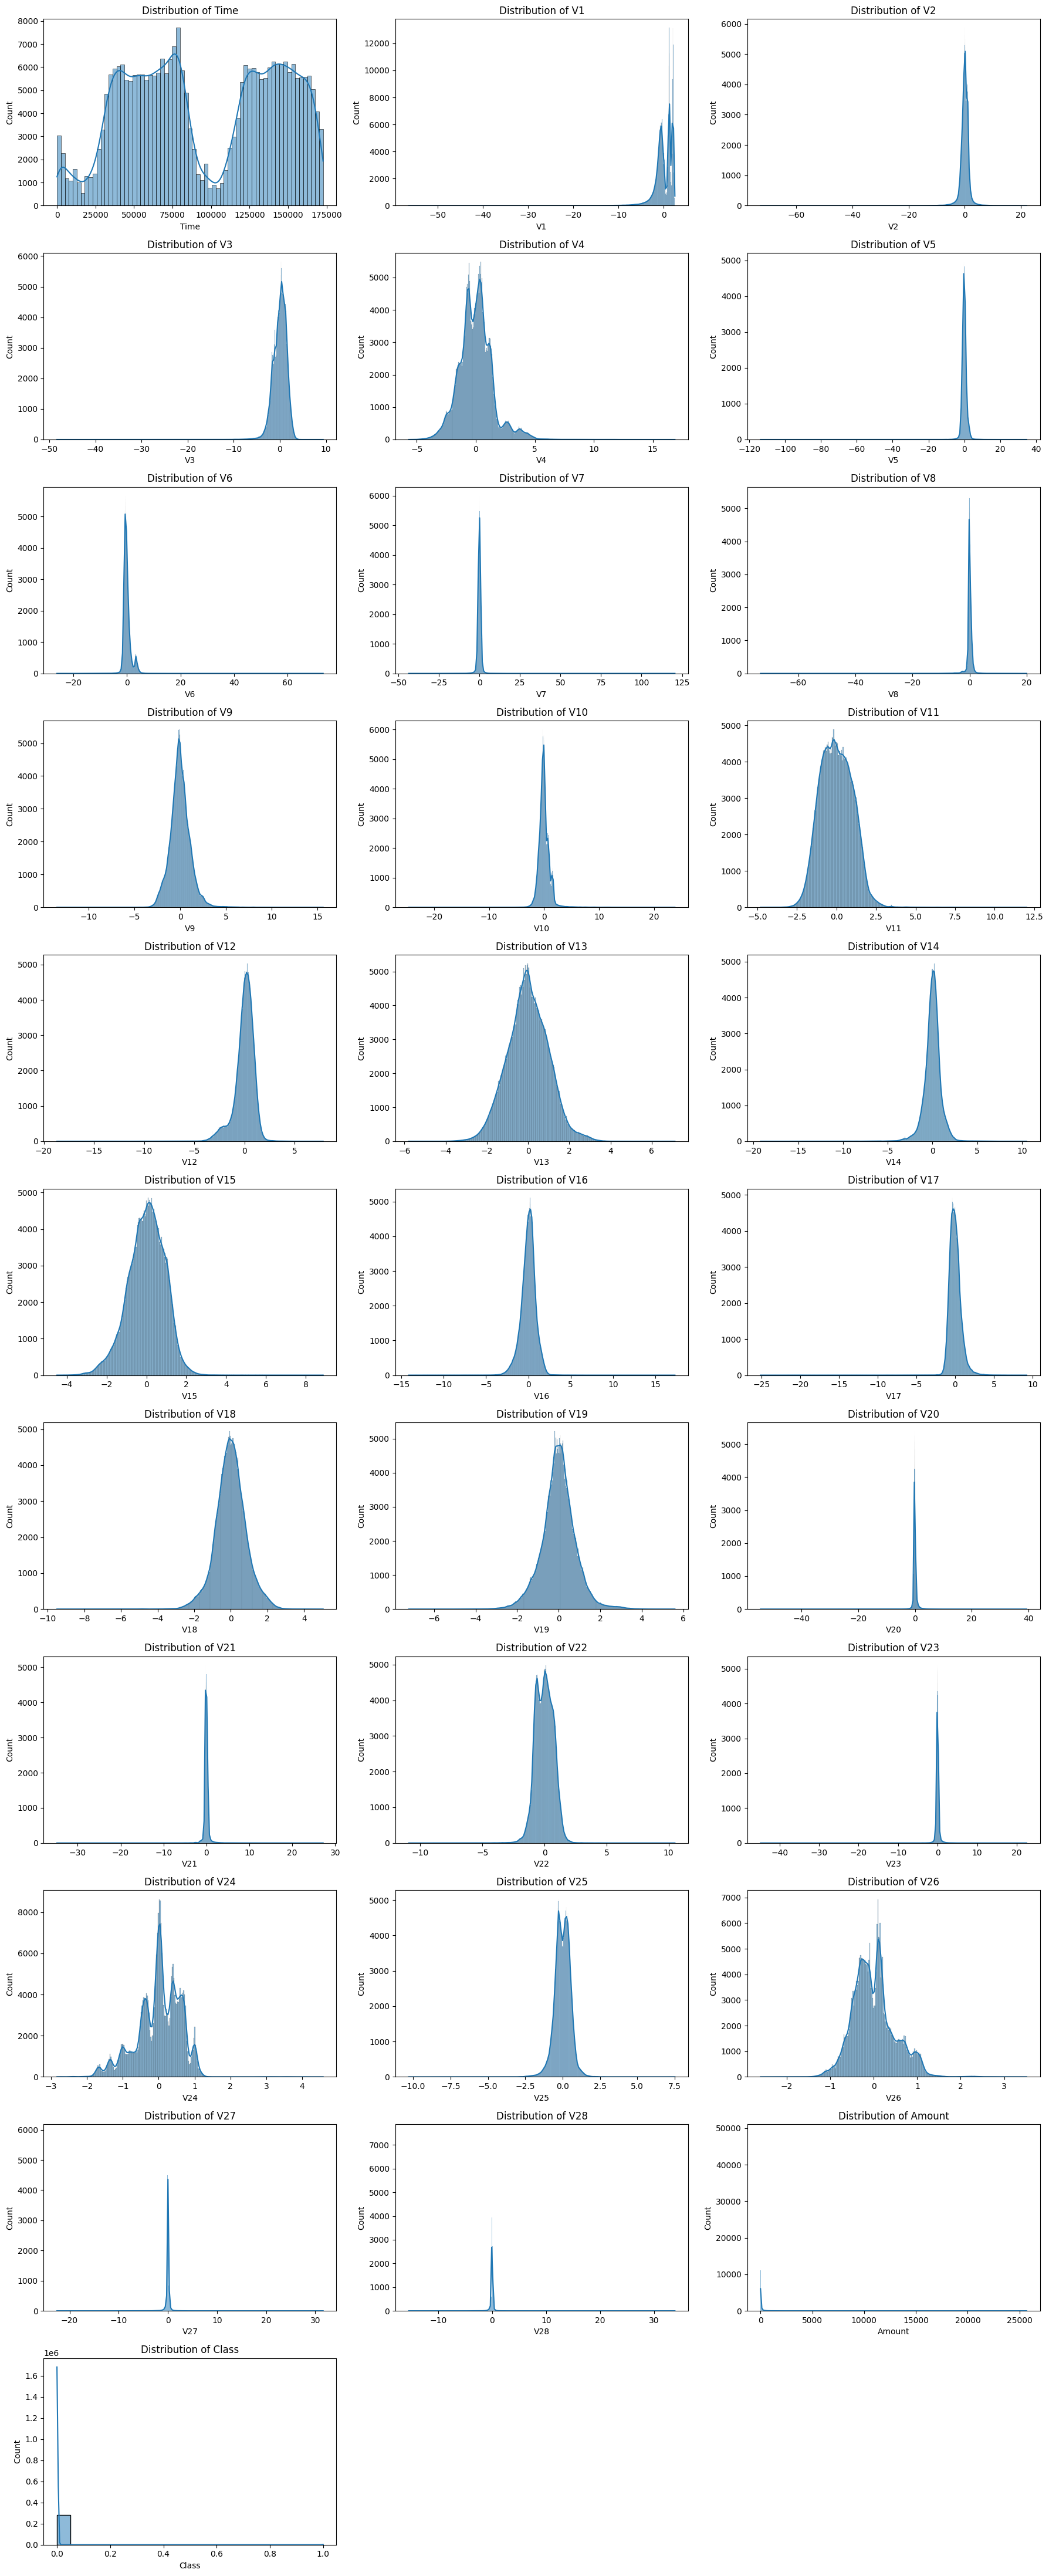

In [20]:
# Visualize the distribution of numerical features
numerical_features = creditcard_df.select_dtypes(include=['float64', 'int64']).columns
num_features_count = len(numerical_features)
num_rows = (num_features_count + 2) // 3  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 3, figsize=(18, 4 * num_rows))
for idx, feature in enumerate(numerical_features):
    row = idx // 3
    col = idx % 3
    sns.histplot(data=creditcard_df, x=feature, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')


if num_features_count < num_rows * 3:
    for ax in axes.flatten()[num_features_count:]:
        ax.remove()

plt.tight_layout()
plt.show()



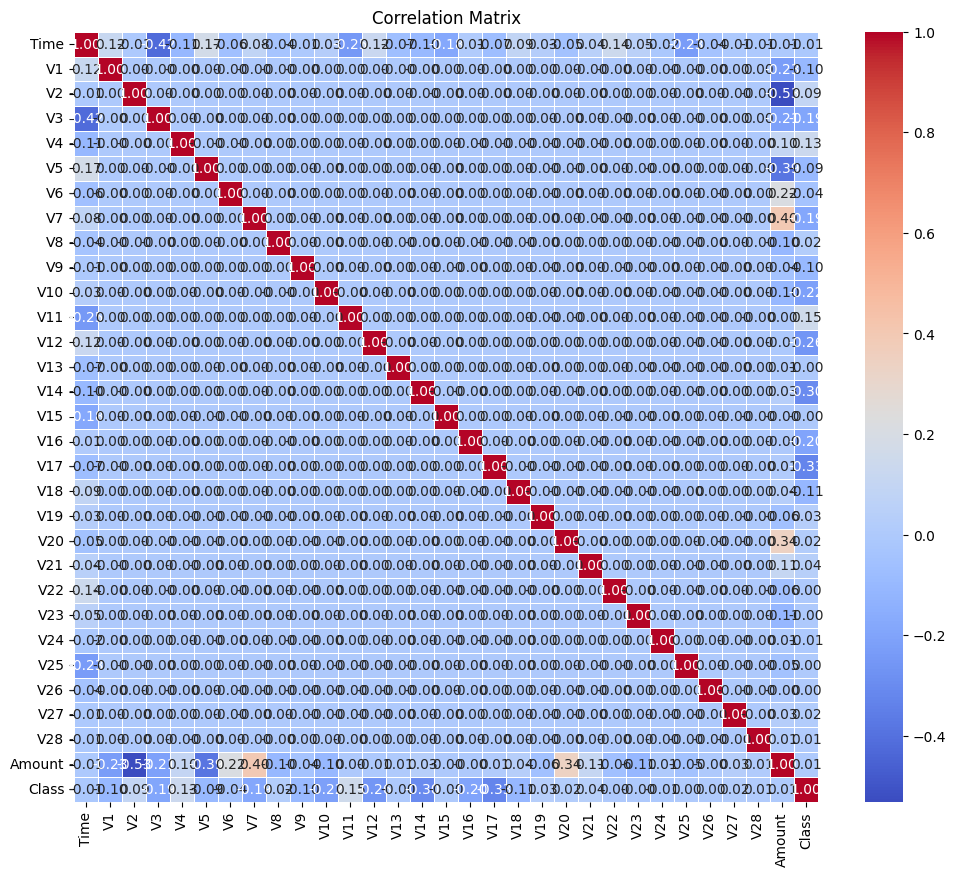

In [23]:
# Visualize the correlation between numerical features
correlation_matrix = creditcard_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Making dataset for PU learning

In [24]:
# Selecting rows for class=1
class_1_df = creditcard_df[creditcard_df['Class'] == 1]
# Select rows equal to len(class_1) for class=0 
class_0_df = creditcard_df[creditcard_df['Class'] == 0].sample(n=len(class_1_df), random_state=42)

balanced_df = pd.concat([class_1_df, class_0_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_df['Class'].value_counts())

Class
0    492
1    492
Name: count, dtype: int64


In [26]:

PU_df = balanced_df.copy()  # Create a copy of the balanced DataFrame

# Select randomly 92 rows where Class = 1 and set Class = 'unknown'
class_1_indices = PU_df[PU_df['Class'] == 1].sample(n=92, random_state=42).index
PU_df.loc[class_1_indices, 'Class'] = 'unknown'

# Set all rows where Class = 0 to Class = 'unknown'
PU_df.loc[PU_df['Class'] == 0, 'Class'] = 'unknown'

# Step 2: Splitting the dataset into training and testing sets
X = PU_df.drop(columns=['Class'])
y = PU_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


C:\Users\FH-Deg\AppData\Local\Temp\7\ipykernel_4328\533568886.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'unknown' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  PU_df.loc[class_1_indices, 'Class'] = 'unknown'


# Gradient policy PU algorithm <br>

<img src="../images/algo.PNG" alt="Getting started" />
<img src="../images/PU_drw.PNG" alt="Getting started" />

for # Step 3: Training a Reinforcement Learning Algorithm
1st I want to train reinforcement algo on 492 positive and 492 Negative examples (if pre-training example is possible)
2: then pass dataset instance to reinforcement algo with class=unknow label and the action will be selection of class, either class belongs to  Fraud (1) or Not-Fraude (0). for whole dataset.
3: then pass this estimated labels from agent to Random Forest classifer to generate probablistic out-come, and that outcome then use as reward for Reinforcement Learning Algorithm.



In [33]:
import gym
from gym import spaces
import numpy as np
from sklearn.ensemble import RandomForestClassifier

class CustomEnv(gym.Env):
    def __init__(self, X, y, balanced_df):
        super(CustomEnv, self).__init__()
        # Define observation space (state space)
        self.observation_space = spaces.Box(low=0, high=1, shape=(X.shape[1],), dtype=np.float32)
        
        # Define action space
        self.action_space = spaces.Discrete(2)  # Binary action space (0 or 1)
        
        # Initialize dataset and labels
        self.X = X
        self.y = y
        self.current_index = 0
        self.bal_X = balanced_df.drop(columns=['Class']).values
        self.bal_y = balanced_df['Class'].values
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        
        # Set episode length
        self.episode_length = len(X)
        self.classifier.fit(self.bal_X, self.bal_y)
        
    def reset(self):
        # Reset environment to initial state
        self.current_index = 0
        return self._get_observation()
    
    def step(self, action):
        # Take action and return next observation, reward, done, and additional information
        observation = self._get_observation()
        reward = self._get_reward(observation, action)
        self.current_index += 1
        done = self.current_index >= self.episode_length
        return observation, reward, done, {}
    
    def _get_observation(self):
        # Get current observation (state)
        return self.X[self.current_index]
    
    def _get_reward(self, observation, action):
        # Get reward based on the action taken and the observation
        # Use the classifier to predict the probability
        y_hat = self.classifier.predict_proba([observation])[0][1]  # Probability of being positive (fraud)
        
        if action == 1:  # Fraud (positive class)
            if y_hat >= 0.5:  # Predicted probability is greater than or equal to threshold
                return self.y[self.current_index]
            else:
                return 1 - self.y[self.current_index]
        else:  # Not-Fraud (negative class)
            return self.y[self.current_index]


In [32]:
env = CustomEnv(X_train.to_numpy(), y_train.to_numpy(), balanced_df)
# Create an instance of CustomEnv
# env = CustomEnv(balanced_df)

# Reset the environment to its initial state
observation = env.reset()

# Run for a fixed number of steps (or episodes)
num_steps = 1000
total_reward = 0

for step in range(num_steps):
    # Choose an action (0 or 1) randomly for demonstration
    action = env.action_space.sample()
    
    # Take a step in the environment
    next_observation, reward, done, _ = env.step(action)
    
    # Accumulate the reward
    total_reward += reward
    
    # Print the current observation, action, reward, and whether the episode is done
    print("Step:", step)
    print("Observation:", observation)
    print("Action:", action)
    print("Reward:", reward)
    print("Done:", done)
    print("----------------------")
    
    # Update the current observation
    observation = next_observation
    
    # Break the loop if the episode is done
    if done:
        break

# Print the total reward accumulated during the run
print("Total Reward:", total_reward)


Step: 0
Observation: [ 9.38790000e+04 -1.28336314e+01  7.50878981e+00 -2.04919522e+01
  7.46577999e+00 -1.15753037e+01 -5.14099948e+00 -1.40205637e+01
  8.33212047e+00 -4.33771253e+00 -1.55637913e+01  7.61081979e+00
 -1.55923232e+01  5.04789055e-01 -1.32478886e+01 -7.96526030e-01
 -1.03423284e+01 -1.60445243e+01 -5.88213594e+00  1.57369790e+00
 -1.37892322e+00  2.96684240e+00  6.15344322e-01 -7.66494757e-01
  4.31261005e-01 -1.04974995e-01 -1.00913271e-02 -2.40081135e+00
 -7.20556600e-01  1.04030000e+02]
Action: 1
Reward: 1
Done: False
----------------------


TypeError: unsupported operand type(s) for -: 'int' and 'str'

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from stable_baselines3 import DQN  # or any other RL algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

# Assuming PU_df contains the processed DataFrame with 'Class' as 'unknown' for the instances

# Step 1: Pre-training the Reinforcement Learning Algorithm
pre_train_df = balanced_df.sample(n=492*2, random_state=42)  # 492 positive + 492 negative
X_pre_train = pre_train_df.drop(columns=['Class'])
y_pre_train = pre_train_df['Class']
pre_model = DQN(...)  # Initialize the RL algorithm
pre_model.learn(X_pre_train, y_pre_train)

# Step 2: Reinforcement Learning on PU Dataset
X_pu = PU_df.drop(columns=['Class'])
actions = pre_model.predict(X_pu)  # Actions selected by the RL agent

# Step 3: Reward Generation
rf_classifier = RandomForestClassifier(...)  # Initialize the Random Forest classifier
rf_classifier.fit(X_pre_train, y_pre_train)
proba_outcome = rf_classifier.predict_proba(X_pu)[:, 1]  # Probability of being positive (fraud)

# Use probability as reward (you may need to customize this)
rewards = proba_outcome

# Use rewards to update the reinforcement learning model (e.g., Q-values)
pre_model.learn(X_pu, actions, rewards)

# Note: This is a high-level outline. You may need to adjust and customize the code based on your specific requirements and the APIs of the reinforcement learning and supervised learning libraries you're using.


Now provide me code for the above steps according to MNIST dataset and you know MNIST contains 10 classes but I want to change even class